In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import cv2
from scipy.io.wavfile import write
from datetime import datetime
import subprocess
import numexpr as ne

# Simulation

In [5]:
def get_interpolated(array, index):
    if not hasattr(index, "__len__") or len(index) < 1: return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [6]:
def interpolate_1d(array, indices):
    return (1 - (indices % 1)) * array[np.floor(indices).astype(np.int64)] + (indices % 1) * array[np.ceil(indices).astype(np.int64)]

In [7]:
interpolate_1d(np.array([[1, 2],[3, 4]]), np.array([0.5]))

array([[2., 3.]])

In [8]:
def gaussian(x, y, n, offset, width):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return np.exp(-(x*x + y*y) / (width*width)) + 0j

In [9]:
def parabolar(x, y, n, offset, factor):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return factor * (x*x + y*y)


In [10]:
def calculate_next_psi(psi, dt, potential):
    n = psi.shape[0]
    next_psi = np.zeros((n, n), dtype=np.complex_)

    # potential-part
    next_psi = psi * np.exp(1j * dt * potential)

    next_psi = np.fft.fft2(next_psi)
    
    indices = 2 * np.pi * np.min([np.arange(n), n-np.arange(n)], axis=0)
    k = indices.reshape(-1, 1)
    l = indices.reshape(1, -1)
    theta = (k*k + l*l) * dt
    next_psi *= np.exp(1j * theta)

    next_psi = np.fft.ifft2(next_psi)
    return next_psi

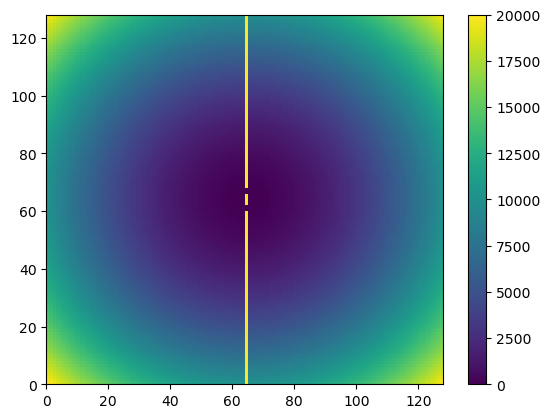

Finished simulation


In [11]:
n = 128
fps = 400
skip_frames = 20
duration = 5
simulation_speed = 0.005

slits_distance = 4
slits_width = 2
wall_height = 1e60

frames = [] # for storing the generated images

psi = np.array([[gaussian(x, y, n, offset=[-0.6, 0.0], width=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[parabolar(x, y, n, offset=[0,0], factor=10000) for x in range(n)] for y in range(n)])
potential[:64-slits_distance//2-slits_width, 64] = wall_height
potential[64+slits_distance//2+slits_width:, 64] = wall_height
potential[64-slits_distance//2:64+slits_distance//2, 64] = wall_height
frames.append(psi)

#plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
plt.pcolormesh(potential, vmin=0, vmax=20000)
plt.colorbar()
plt.show()


for i in range(fps*duration):
    psi = calculate_next_psi(psi, simulation_speed / fps, potential)
    frames.append(psi)

print("Finished simulation")

# Video

In [12]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_filename = f'simulation_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'
video = cv2.VideoWriter(video_filename, fourcc, fps/skip_frames, (800, 600))
for i, frame in enumerate(frames[::skip_frames]):
    plt.figure(figsize=(8, 6))
    plot = plt.pcolormesh(pow(np.abs(frame), 2.0/3.0), cmap='inferno', vmin=0, vmax=1, animated=True)
    plt.colorbar()
    plt.title('psi')

    # Save to temporary file
    plt.savefig('temp_frame.png')
    plt.close()

    # Read the image and add to the video
    img = cv2.imread('temp_frame.png')
    video.write(img)

print(f"Video saved as {video_filename}")
video.release()

Video saved as simulation_2024_04_10-12_40_27.mp4


# Sonification

In [13]:
a = np.array([[1, 1], [23, 23]])
b = np.array([[2, 2], [25, 23]])
spring_length = 0.5

difference = a - b
force = difference * ((np.linalg.norm(difference, axis=1) - spring_length) / np.linalg.norm(difference, axis=1))[:, np.newaxis]

np.linalg.norm(force, axis=1)

array([0.91421356, 1.5       ])

In [214]:
average_parallel_listening = lambda array: np.average(array[:, :, 0])
average_orthogonal_listening = lambda array: np.average(array[:, :, 1])
average_norm_listening = lambda array: np.average(np.linalg.norm(array, axis=2))

point_parallel_listening = lambda array: array[20, 60, 0]
point_orthogonal_listening = lambda array: array[20, 60, 1]

In [221]:
positions = np.indices((4, 4)).transpose((1, 2, 0))
springs = np.indices((4, 4)).transpose((1, 2, 0))[:, :, np.newaxis, :] + [[[[-1, 0], [1, 0], [0, -1], [0, 1]]]] # indices for each connected mass point for each mass point shape: (x, y, num_springs, indices_of_other_point


positions[0, 0]

array([0, 0])

In [211]:
offsets = positions[springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1]] - positions[1:-1, 1:-1, np.newaxis, :]
distances = np.linalg.norm(offsets, axis=3)[:, :, :, np.newaxis]

forces = np.sum(1 * offsets * (distances - 1) / distances, axis=2)  # spring_amount, real spring length

forces

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [226]:
springs = np.indices((n, n)).transpose((1, 2, 0))[:, :, np.newaxis, :] + [[[[-1, 0], [1, 0], [0, -1], [0, 1]]]] # indices for each connected mass point for each mass point shape: (x, y, num_springs, indices_of_other_point
data = interpolate_1d(frames, 0.1)
angles = np.angle(data)
springs_length = 1 - np.cos(angles[springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1]] - angles[1:-1, 1:-1, np.newaxis])

In [ ]:
sample_rate = 44100
sonification_duration = 2
sonification_duration = np.min([duration, sonification_duration])

springs = np.indices((n, n)).transpose((1, 2, 0))[:, :, np.newaxis, :] + [[[[-1, 0], [1, 0], [0, -1], [0, 1]]]] # indices for each connected mass point for each mass point shape: (x, y, num_springs, indices_of_other_point
original_positions = np.indices((n, n), dtype=np.float64).transpose((1, 2, 0))

# Pre interpolation
num_simulated_steps = sonification_duration * sample_rate
data = interpolate_1d(np.array(frames), np.arange(num_simulated_steps) / sample_rate * fps)

In [ ]:
plt.pcolormesh(data[34895])

In [227]:
listening = average_orthogonal_listening

dampening_per_second = 1 - 1e-12
spring_amount = sample_rate * 10
min_mass = 0.00125
max_mass = 3.2



dampening_per_sample = 1 - pow(1 - dampening_per_second, 1 / sample_rate)

0


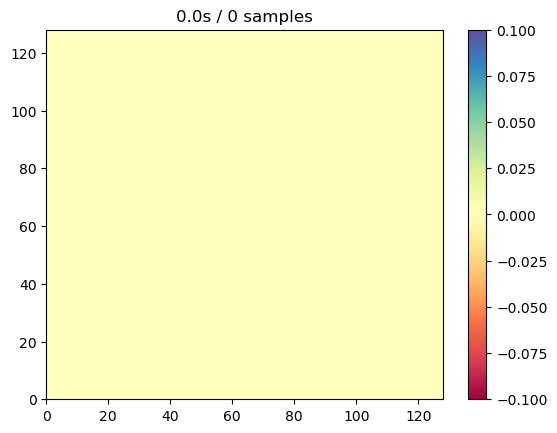

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


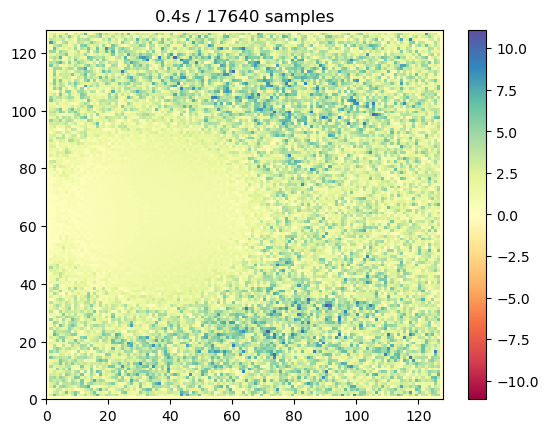

17641
17642
17643
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
17675
17676
17677
17678
17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
1780

KeyboardInterrupt: 

In [238]:
positions = np.copy(original_positions)
speeds = np.zeros((n, n, 2), dtype=np.float64)


audio = np.empty(num_simulated_steps)

for sample in range(num_simulated_steps):
    print(sample)
    
    last_data = data
    data = interpolate_1d(frames, sample / sample_rate * fps)
    
    masses = min_mass + (max_mass - min_mass) * np.abs(data)
    angles = np.angle(data)
    springs_length = 1 - np.cos(angles[springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1]] - angles[1:-1, 1:-1, np.newaxis])
    springs_length = springs_length[:, :, :, np.newaxis]
    

    forces = np.zeros((n, n, 2))

    offsets = positions[springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1]] - positions[1:-1, 1:-1, np.newaxis, :]
    distances = np.linalg.norm(offsets, axis=3)[:, :, :, np.newaxis]

    forces[1:-1, 1:-1] = np.sum(spring_amount * offsets * (distances - springs_length) / distances, axis=2) # apply springs force
    
    # Add noise
    forces[1:-1, 1:-1, 0] += np.abs(np.abs(last_data) - np.abs(data))[1:-1, 1:-1] * (2 * np.random.random((n-2, n-2)) - 1)

    # Update speeds with forces, apply dampening
    speeds += forces / masses[:, :, np.newaxis] / sample_rate
    speeds *= 1 - dampening_per_sample #/ masses[:, :, np.newaxis]
    
    positions += speeds / sample_rate

    audio[sample] = listening(positions - original_positions)

    #'''
    if sample % (sample_rate * sonification_duration // 5) == 0:
        plot_data = np.abs(np.linalg.norm(positions - original_positions, axis=2))
        scale = np.max(plot_data)
        plt.pcolormesh(plot_data, vmin=-scale, vmax=scale, cmap='Spectral')
        plt.colorbar()
        plt.title(f"{round(sample/sample_rate, 2) }s / {sample} samples")
        plt.show()
    #'''

In [157]:
audio[:1000]  *= np.square(np.linspace(start=0, stop=1, num=1000, endpoint=False))
audio[-1000:] *= np.square(np.linspace(start=1, stop=0, num=1000, endpoint=False))
audio_filename = f'sonification_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.wav'
write(audio_filename, sample_rate, np.round((audio - np.average(audio)) / np.max(np.abs(audio - np.average(audio))) * 32767).astype(np.int16))
print(f"Sonification saved as {audio_filename}")
Audio(audio, rate=sample_rate)

Sonification saved as sonification_2024_04_09-16_44_44.wav


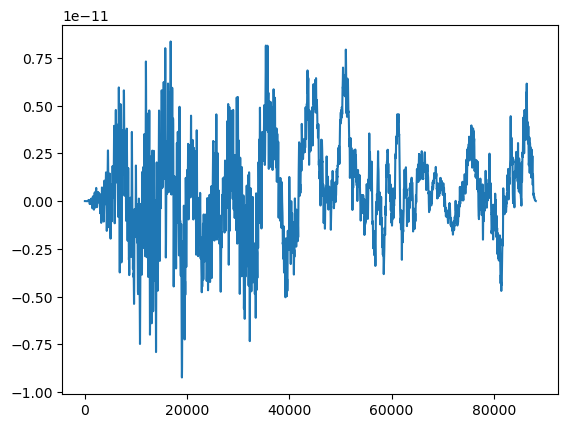

In [158]:
plt.plot(audio)

# Combine Audio & Video

In [159]:
combined_filename = f'combination_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

# Construct the ffmpeg command to combine video and audio
ffmpeg_command = [
    './ffmpeg',
    '-i', video_filename,   # Input video file
    '-i', audio_filename,   # Input audio file
    '-c:v', 'copy',         # Copy the video stream
    '-c:a', 'aac',          # Encode the audio to AAC (necessary for some formats)
    '-shortest',            # Finish encoding when the shortest input stream ends
    combined_filename         # Output file
]

# Execute the command
subprocess.run(ffmpeg_command)

ffmpeg version 6.1.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--stat

CompletedProcess(args=['./ffmpeg', '-i', 'simulation_2024_04_09-14_43_52.mp4', '-i', 'sonification_2024_04_09-16_44_44.wav', '-c:v', 'copy', '-c:a', 'aac', '-shortest', 'combination_2024_04_09-16_44_44.mp4'], returncode=0)